In [10]:
import openai
import pandas as pd
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# Verify OpenAI library version
print(f"OpenAI library version: {openai.__version__}")  # Should print 0.28.0

OpenAI library version: 0.28.0


In [12]:
# Load your dataset
print("Loading dataset...")
data = pd.read_csv(r"C:\Users\monbi\OneDrive\Documents\BSE\Term 3\Masters Thesis\ECB_Perceived_Cacophony\Scraped_Data\ecb_monetary_policy_decisions.csv")
print("Dataset loaded successfully.")
data


Loading dataset...
Dataset loaded successfully.


,Date,Title,Link,Article
0,11 April 2024,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2024/...,The Governing Council today decided to keep th...
1,7 March 2024,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2024/...,The Governing Council today decided to keep th...
2,25 January 2024,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2024/...,The Governing Council today decided to keep th...
3,14 December 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,The Governing Council today decided to keep th...
4,26 October 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,The Governing Council today decided to keep th...
5,14 September 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation continues to decline but is still ex...
6,27 July 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation continues to decline but is still ex...
7,27 July 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation continues to decline but is still ex...
8,15 June 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation has been coming down but is projecte...
9,4 May 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,The inflation outlook continues to be too high...


In [13]:
# Drop rows where 'Article' is NaN and reset index
print("Cleaning dataset...")
data.dropna(subset=['Article'], inplace=True)
data.reset_index(drop=True, inplace=True)
print("Dataset cleaned.")

# Set your OpenAI API key
openai.api_key = 'sk-proj-q4vaD1sfS4JM31othrf0T3BlbkFJCdvyWyHUWXfivw7iteZj'

def classify_and_score_article(article):
    # Formulate the prompt
    prompt = (
        "Classify the following article as 'Dovish' or 'Hawkish' and provide a score between -1 and 1 indicating how dovish or hawkish it is.\n"
        "\n"
        "An article is 'Dovish' if it suggests policies or sentiments that are supportive of economic growth, low interest rates, or monetary easing.\n"
        "An article is 'Hawkish' if it suggests policies or sentiments that are supportive of combating inflation, high interest rates, or monetary tightening.\n"
        "\n"
        "The score should be between -1 and 1 where -1 indicates extremely dovish and 1 indicates extremely hawkish.\n"
        "\n"
        "Article: {}\n"
        "\n"
        "Provide the output in the following format:\n"
        "Classification: [Dovish/Hawkish]\n"
        "Score: [score]\n"
        "Explanation: [Explanation]\n".format(article)
    )
    
    # Call the GPT-3.5-turbo API using the updated method
    while True:
        try:
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a financial expert."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150  # Adjust max_tokens if needed
            )
            # Extract the classification and score from the response
            result = response['choices'][0]['message']['content'].strip()

            # Extract classification, score, and explanation using regex
            classification = re.search(r"Classification:\s*(Dovish|Hawkish)", result)
            score = re.search(r"Score:\s*(-?\d+\.\d+)", result)
            explanation = re.search(r"Explanation:\s*(.*)", result, re.DOTALL)

            if classification and score and explanation:
                return classification.group(1), score.group(1), explanation.group(1).strip()
            else:
                raise ValueError("Incomplete response from API")

        except openai.error.RateLimitError:
            print("Rate limit exceeded. Retrying in 10 seconds...")
            time.sleep(10)
        except openai.error.APIError as e:
            print(f"API error: {e}. Retrying in 10 seconds...")
            time.sleep(10)
        except Exception as e:
            print(f"Unexpected error: {e}. Skipping this article.")
            return "Error", "Error", "Error"

# Initialize new columns
data['Classification'] = ""
data['Score'] = ""
data['Explanation'] = ""

# Classify and score each article in the dataset
print("Classifying and scoring articles...")
for i, article in enumerate(data['Article']):
    classification, score, explanation = classify_and_score_article(article)
    data.loc[i, 'Classification'] = classification
    data.loc[i, 'Score'] = score
    data.loc[i, 'Explanation'] = explanation
    if (i + 1) % 10 == 0 or (i + 1) == len(data):
        print(f"Processed {i + 1} of {len(data)} articles.")

# Display the first few rows of the updated dataframe
print("Classification and scoring completed for monetary policy statements. Here are the first few results:")
print(data.head())

# Optionally, save the results to a new Excel file
output_file = 'classified_articles.xlsx'
data.to_excel(output_file, index=False)
print(f"Results saved to {output_file}")


Cleaning dataset...
Dataset cleaned.
Classifying and scoring articles...
Unexpected error: Incomplete response from API. Skipping this article.
Processed 10 of 31 articles.
Processed 20 of 31 articles.
Processed 30 of 31 articles.
Processed 31 of 31 articles.
Classification and scoring completed for monetary policy statements. Here are the first few results:
               Date                     Title  \
0     11 April 2024  MONETARY POLICY DECISION   
1      7 March 2024  MONETARY POLICY DECISION   
2   25 January 2024  MONETARY POLICY DECISION   
3  14 December 2023  MONETARY POLICY DECISION   
4   26 October 2023  MONETARY POLICY DECISION   

                                                Link  \
0  https://www.ecb.europa.eu//press/pr/date/2024/...   
1  https://www.ecb.europa.eu//press/pr/date/2024/...   
2  https://www.ecb.europa.eu//press/pr/date/2024/...   
3  https://www.ecb.europa.eu//press/pr/date/2023/...   
4  https://www.ecb.europa.eu//press/pr/date/2023/...   

       

In [14]:
data

,Date,Title,Link,Article,Classification,Score,Explanation
0,11 April 2024,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2024/...,The Governing Council today decided to keep th...,Hawkish,0.7,The article suggests a hawkish sentiment as it...
1,7 March 2024,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2024/...,The Governing Council today decided to keep th...,Hawkish,0.8,The article suggests a hawkish sentiment as th...
2,25 January 2024,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2024/...,The Governing Council today decided to keep th...,Hawkish,0.7,The article suggests a hawkish stance by indic...
3,14 December 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,The Governing Council today decided to keep th...,Hawkish,0.6,The article suggests a hawkish stance as it hi...
4,26 October 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,The Governing Council today decided to keep th...,Hawkish,0.7,The article indicates a hawkish stance as it e...
5,14 September 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation continues to decline but is still ex...,Hawkish,0.8,The article suggests a hawkish stance by stati...
6,27 July 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation continues to decline but is still ex...,Hawkish,0.8,The article suggests a hawkish stance as it hi...
7,27 July 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation continues to decline but is still ex...,Hawkish,0.8,The article indicates a hawkish stance by stat...
8,15 June 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,Inflation has been coming down but is projecte...,Hawkish,0.8,The article indicates a hawkish stance as the ...
9,4 May 2023,MONETARY POLICY DECISION,https://www.ecb.europa.eu//press/pr/date/2023/...,The inflation outlook continues to be too high...,Error,Error,Error


      Date  Score   Color
2021-01-21   -0.9 #1E90FF
2021-03-11   -0.8 #1E90FF
2021-04-22   -0.8 #1E90FF
2021-06-10   -0.8 #1E90FF
2021-07-22   -0.8 #1E90FF
2021-09-09   -0.5 #1E90FF
2021-10-28   -0.6 #1E90FF
2021-12-16    0.7 #FFD700
2022-02-03   -0.8 #1E90FF
2022-03-10   -0.7 #1E90FF
2022-04-14    0.5 #FFD700
2022-06-09    0.9 #FFD700
2022-07-21    0.8 #FFD700
2022-07-21    0.9 #FFD700
2022-09-08    0.9 #FFD700
2022-09-08    0.9 #FFD700
2022-10-27    0.8 #FFD700
2022-10-27    0.8 #FFD700
2022-12-15    0.9 #FFD700
2023-02-02    0.9 #FFD700
2023-03-16    0.8 #FFD700
2023-05-04    NaN #1E90FF
2023-06-15    0.8 #FFD700
2023-07-27    0.8 #FFD700
2023-07-27    0.8 #FFD700
2023-09-14    0.8 #FFD700
2023-10-26    0.7 #FFD700
2023-12-14    0.6 #FFD700
2024-01-25    0.7 #FFD700
2024-03-07    0.8 #FFD700
2024-04-11    0.7 #FFD700


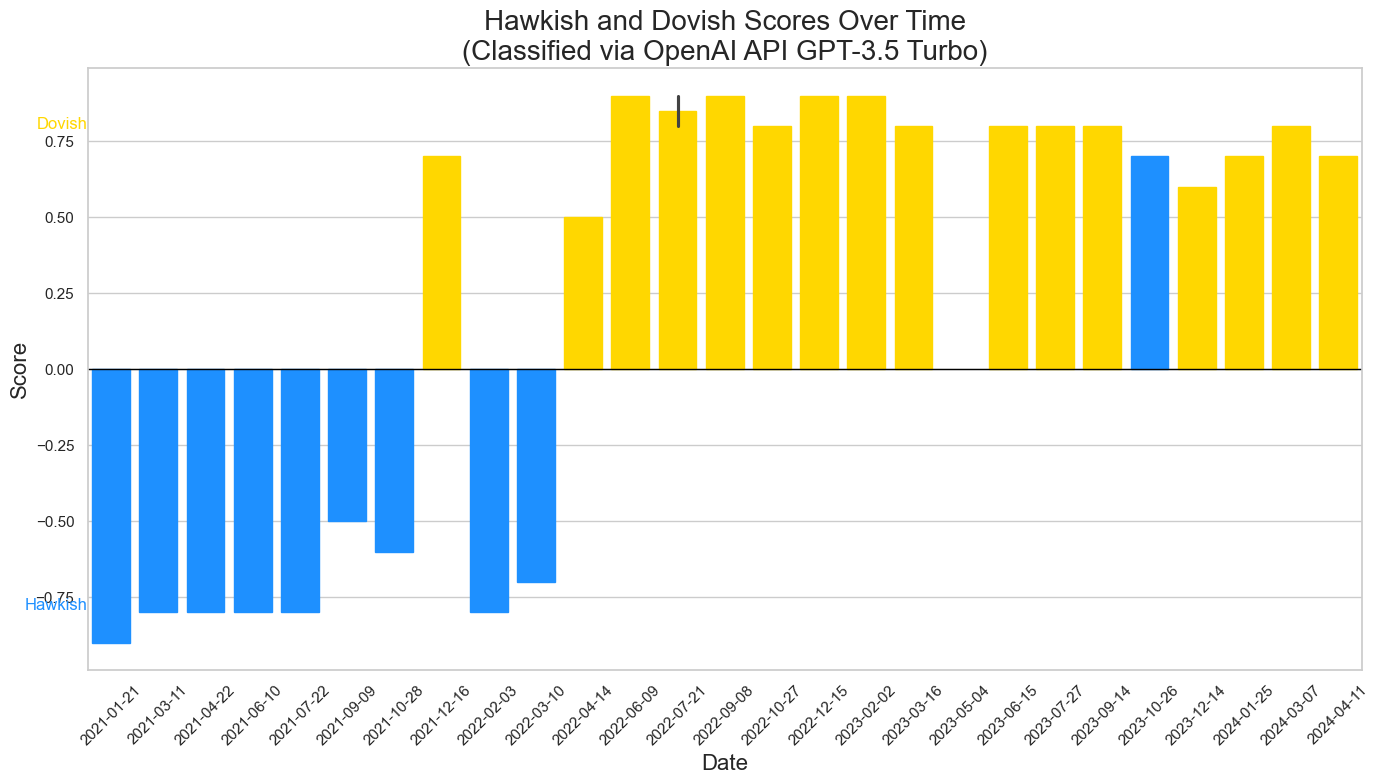

In [18]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Convert 'Score' column to numeric, forcing errors to NaN (we can handle them later if needed)
data['Score'] = pd.to_numeric(data['Score'], errors='coerce')

# Sort data by date
data = data.sort_values(by='Date')

# Set the color palette to match the requested colors (yellow for dovish and blue for hawkish)
def get_color(score):
    return '#FFD700' if score > 0 else '#1E90FF'

data['Color'] = data['Score'].apply(get_color)

# Verify the data
print(data[['Date', 'Score', 'Color']].to_string(index=False))

# Create the seaborn bar plot without the palette argument
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Create a bar plot without specifying the palette
bar_plot = sns.barplot(
    x='Date', 
    y='Score', 
    data=data,
    edgecolor='black'
)

# Apply the custom colors using matplotlib
for i, bar in enumerate(bar_plot.patches):
    bar.set_color(data['Color'].iloc[i])

# Customize the plot
bar_plot.set_title('Hawkish and Dovish Scores Over Time\n(Classified via OpenAI API GPT-3.5 Turbo)', fontsize=20)
bar_plot.set_xlabel('Date', fontsize=16)
bar_plot.set_ylabel('Score', fontsize=16)
bar_plot.axhline(0, color='black', linewidth=1)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add annotations to make the y-axis clear
bar_plot.annotate('Dovish', xy=(0, 0.9), xycoords='axes fraction', fontsize=12, color='#FFD700', ha='right')
bar_plot.annotate('Hawkish', xy=(0, 0.1), xycoords='axes fraction', fontsize=12, color='#1E90FF', ha='right')

# Show the plot
plt.tight_layout()
plt.show()